In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bioAI.mplstyle")
import torch
import tqdm
import scipy

import sys
sys.path.append('../')
from methods import permutation_test
from models import JitterCI
from plotting_functions import set_size, colorbar_axis
from utils import rotation_matrix

In [3]:
color_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']
savefigs = False
dpi=150

In [4]:
def train_model(model, nsamples_space=2**8, epochs=2000):
    # Train model
    loss_history = []
    metric_history = []
    phases_history = [model.phases.clone().detach().numpy()]
    G_history = []
    for epoch in tqdm.trange(epochs):
        rs = model.unit_cell.sample(nsamples_space)
        rs = torch.tensor(rs,dtype=torch.float32)
        loss = model.train_step(rs)
        metric = model.CI_metric(r=rs).item()
        G_history.append(model.metric_tensor(model.jacobian(rs)).detach().numpy())
        loss_history.append(loss)
        phases_history.append(model.phases.clone().detach().numpy())
        metric_history.append(metric)
    phases_history[-1] = model.unit_cell.wrap(phases_history[-1])
    loss_history = np.array(loss_history)
    metric_history = np.array(metric_history)
    phases_history = np.array(phases_history)
    G_history = np.array(G_history)
    return loss_history, phases_history, metric_history, G_history

In [ ]:
# load trained model
dtype = torch.float32
#model = JacobianCI(ncells=7*15,dtype=dtype,lr=1e-3, shift=0, p_magnitude=0)
models = []
nmodels = 50
epochs = 500
for i in range(nmodels):
    model = JitterCI(ncells=7*30,dtype=dtype,lr=1e-3, shift=0, p_magnitude=0)
    loss_history, phases_history, metric_history, G_history = train_model(model,epochs=epochs)
    # set best phases based on lowest loss
    #best_phases = phases_history[np.argmin(loss_history)+1]
    #model.set_phases(best_phases)
    models.append(model)

 12%|█▏        | 60/500 [00:01<00:08, 51.88it/s]

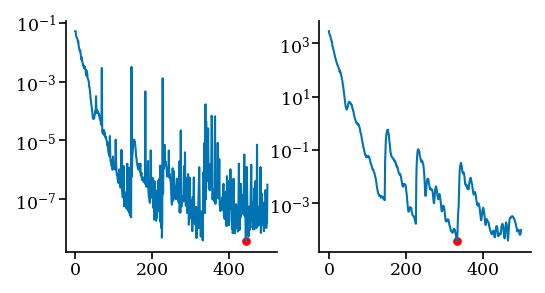

In [7]:
fig, axs = plt.subplots(1,2,figsize=(4,2))
axs[0].semilogy(loss_history)
axs[0].scatter(np.argmin(loss_history),np.min(loss_history), s=10, c='red')
axs[1].semilogy(metric_history)
axs[1].scatter(np.argmin(metric_history),np.min(metric_history), s=10, c='red')

(-0.7333333333333333,
 0.7333333333333333,
 -0.6350852961085885,
 0.6350852961085884)

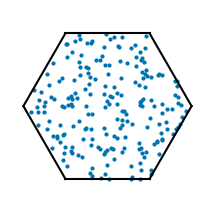

In [8]:
fig,ax = model.unit_cell.plot(color='black')
ax.scatter(*phases_history[-1].T,s=1)
ax.axis('equal')
ax.axis('off')

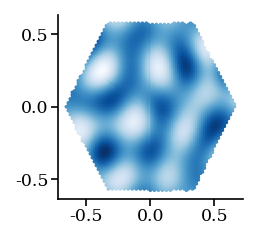

In [9]:
kde, mesh, kernel, expanded_phases = model.phase_kde(bw_method=0.1)
plt.scatter(*mesh.T, c=kde, s=0.5)

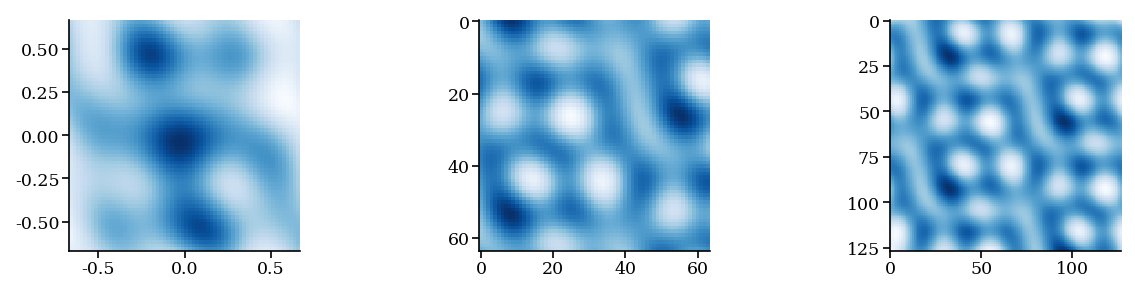

In [10]:
autocorr, ratemap, square_mesh, large_ratemap, large_square_mesh = model.phase_kde_autocorrelogram(bw_method=0.2)
fig,axs = plt.subplots(1,3,figsize=(10,2))
axs[0].imshow(autocorr, extent=[np.min(square_mesh),np.max(square_mesh),np.min(square_mesh),np.max(square_mesh)])
#model.unit_cell.plot(ax=axs[0],color='black')
axs[1].imshow(ratemap)
axs[2].imshow(large_ratemap)

In [11]:
import numpy as np
import tqdm
from joblib import Parallel, delayed

# Given parameters:
nmodels = len(models) 
bins = 20

# Define radii and initialize output arrays:
radii = np.linspace(0, model.unit_cell.radius/2, 21)[1:]
random_grid_scores = np.zeros((nmodels, len(radii)))
optimal_grid_scores = np.zeros((nmodels, len(radii)))
random_freqs = np.zeros((nmodels, bins))
optimal_freqs = np.zeros((nmodels, bins))

# Define the function to compute grid scores and frequencies:
def compute_grid_scores_and_freqs(model, radii, bins=20):
    random_grid_scores = np.zeros(len(radii))
    optimal_grid_scores = np.zeros(len(radii))
    for j, radius in enumerate(radii):
        random_grid_scores[j] = model.grid_score(phases=model.unit_cell.sample(len(model.phases)), bw_method=radius)
        optimal_grid_scores[j] = model.grid_score(bw_method=radius)
    random_freq, _ = np.histogram(random_grid_scores, bins=bins)
    optimal_freq, _ = np.histogram(optimal_grid_scores, bins=bins)
    return random_grid_scores, optimal_grid_scores, random_freq, optimal_freq

# Parallel computation:
n_jobs = -1  # Use all available CPUs. Adjust as necessary.
results = Parallel(n_jobs=n_jobs)(
    delayed(compute_grid_scores_and_freqs)(model, radii, bins) for model in tqdm.tqdm(models)
)

# Unpack the results into your arrays:
for i, (rgs, ogs, rf, of) in enumerate(results):
    random_grid_scores[i] = rgs
    optimal_grid_scores[i] = ogs
    random_freqs[i] = rf
    optimal_freqs[i] = of

100%|██████████| 50/50 [04:24<00:00,  5.29s/it]


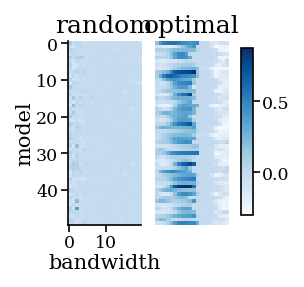

In [12]:
fig,axs = plt.subplots(ncols=2)#,figsize=(6,3))
vmin, vmax = min(np.min(random_grid_scores),np.min(optimal_grid_scores)), max(np.max(random_grid_scores),np.max(optimal_grid_scores))
im0 = axs[0].imshow(random_grid_scores, vmin=vmin, vmax=vmax)
#axs[0].axis('off')
axs[0].set_xlabel('bandwidth')
axs[0].set_ylabel('model')
axs[0].set_title('random')
#colorbar_axis(fig, axs[0], im0)
im1 = axs[1].imshow(optimal_grid_scores, vmin=vmin, vmax=vmax)
axs[1].axis('off')
#axs[1].set_xlabel('bandwidth')
#axs[1].set_ylabel('model')
axs[1].set_title('optimal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im1, cax=cbar_ax)
#colorbar_axis(fig, axs[1], im1)
#plt.tight_layout()

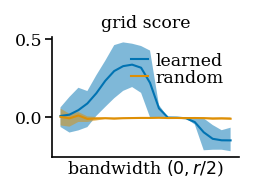

In [13]:
figsize = set_size(fraction=(1/3,1/4),mode='square')
fig, ax = plt.subplots(figsize=figsize)

percentile = 0.2
ax.plot(radii,optimal_grid_scores.mean(axis=0),label='learned')
ax.fill_between(radii,np.sort(optimal_grid_scores,axis=0)[int(nmodels*percentile)],
                np.sort(optimal_grid_scores,axis=0)[int(nmodels*(1-percentile))],alpha=0.5)
ax.plot(radii,random_grid_scores.mean(axis=0),label='random')
ax.fill_between(radii,np.sort(random_grid_scores,axis=0)[int(nmodels*percentile)],
                 np.sort(random_grid_scores,axis=0)[int(nmodels*(1-percentile))],alpha=0.5)

ax.legend()
ax.set_xticks([])
#ax.set_yticks([])
#min_ytick = np.around(np.min([np.min(random_grid_scores)*percentile,np.min(optimal_grid_scores)*percentile]),decimals=1)
#max_ytick = np.around(np.max([np.max(random_grid_scores)*(1-percentile),np.max(optimal_grid_scores)*(1-percentile)]),decimals=1)
ax.set_xlabel('bandwidth ' + r'$(0, r/2$)', fontsize='small')
#ax.set_ylabel('GS ' + '({} {})'.format(min_ytick,max_ytick), fontsize='small')
ax.set_title('grid score', fontsize='small')
fig.tight_layout(pad=0.35, w_pad=0, h_pad=0)

if savefigs:
    fig.savefig('../results/P3-grid_score')

In [14]:
optimal_grid_scores.min(), optimal_grid_scores.max()

(-0.302417873777086, 0.8750498678383717)

## Do Ripleys Statistics on Phases

In [15]:
from joblib import Parallel, delayed

nperms = 200
def calculate_values(radius,seed=0):
    # set seed for sampling phases, such that the random model is the same for all radii 
    rv_models = [model.ripleys(radius) for model in models]
    rv_random = [model.ripleys(radius, phases=models[i].unit_cell.sample(len(models[i].phases),seed=seed+i)) for i in range(len(models))]
    stat, p, H0 = permutation_test(rv_models, rv_random, statistic=None, nperms=nperms, alternative='two-sided')
    return rv_models, rv_random, stat, p, H0

# Using joblib to parallelize the computation
ball_radii = np.linspace(0, model.unit_cell.radius, 21)[1:]
results = Parallel(n_jobs=-1)(delayed(calculate_values)(radius) for radius in ball_radii)
# Unzipping the results into separate lists
ripleys_models, ripleys_random, stats, ps, H0s = zip(*results)
# convert to numpy arrays
ripleys_models, ripleys_random, stats, ps, H0s = np.array(ripleys_models), np.array(ripleys_random), np.array(stats), np.array(ps), np.array(H0s)

100%|██████████| 200/200 [00:00<00:00, 69568.82it/s]


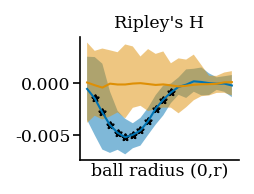

In [17]:
figsize = set_size(fraction=(1/3,1/4),mode='square')
fig, ax = plt.subplots(figsize=figsize)
#plt.rcParams["text.usetex"] = False

ax.plot(ball_radii,ripleys_models.mean(axis=1), label='learned')
percentile = 0.95
ax.fill_between(ball_radii,np.sort(ripleys_models,axis=1)[:,int(nmodels*percentile)],
                 np.sort(ripleys_models,axis=1)[:,int(nmodels*(1-percentile))],alpha=0.5)
ax.plot(ball_radii,ripleys_random.mean(axis=1), label='random')
ax.fill_between(ball_radii,np.sort(ripleys_random,axis=1)[:,int(nmodels*percentile)],
                 np.sort(ripleys_random,axis=1)[:,int(nmodels*(1-percentile))],alpha=0.5)
significance_level = 0.01
mask = ps < significance_level
ax.scatter(ball_radii[mask],ripleys_models.mean(axis=1)[mask],color='black',marker='*',s=10,label='significant')
#ax.set_xlabel(r'$\text{ball radius} (0\rightarrow r)$')
ax.set_xlabel('ball radius ' + r'(0,r)', fontsize='small')
#ax.set_xlabel(r'ball radius (0$\rightarrow$ r)')
ax.set_title("Ripley's H", fontsize='small')
#ax.legend()
#ax.set_position([0.25,0.13,0.8,0.7])
#ax.axis('off')
ax.set_xticks([])
#ax.set_yticks([])
fig.tight_layout(pad=0.35, w_pad=0, h_pad=0)



if savefigs:
    fig.savefig('../results/P3-ripleys')

In [18]:
# Use model and bw_method with highest grid score
# unravel idx
idx_model, idx_radius = np.unravel_index(np.argmax(optimal_grid_scores), optimal_grid_scores.shape)
# get model and radius
best_model = models[idx_model]
best_phases = model.unit_cell.wrap(best_model.phases.detach().numpy())
best_radius = radii[idx_radius]
# select radii for plotting
select_radii_idx = [1, 5, idx_radius, 15]
#select_radii_idx = [1, idx_radius, 15]

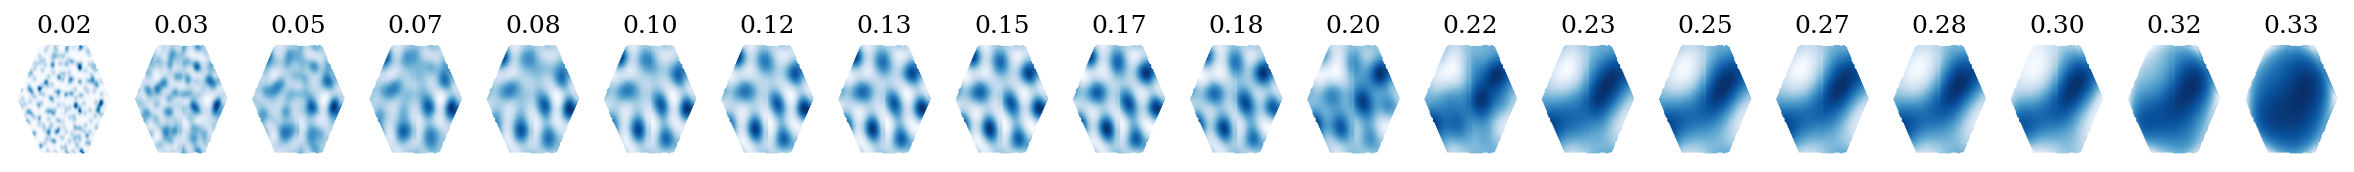

In [19]:
fig, axs = plt.subplots(1,len(radii),figsize=(1*len(radii),1))
for i in range(len(radii)):
    kde, mesh = models[idx_model].phase_kde(bw_method=radii[i])[:2]
    axs[i].scatter(*mesh.T, c=kde, s=0.5)
    axs[i].axis('off')
    axs[i].set_title(f'{radii[i]:.2f}')

0.15683946243954874 2.3171118950240404 0.31740302857119596
0.8264177171307011 0.928181195315246 0.0194678942503323
0.8609099003622387 0.8740333756041275 0.0027699005115322936
0.866012714585542 0.8660354901932377 5.9290295860225496e-06


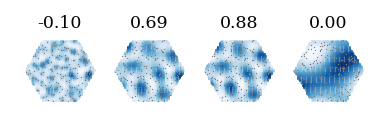

In [37]:
figsize = set_size(fraction=(1/2,1/8),mode='square')
fig, axs = plt.subplots(1,len(select_radii_idx),figsize=figsize)

for i in range(len(select_radii_idx)):
    kde, mesh = best_model.phase_kde(bw_method=radii[select_radii_idx[i]])[:2]
    kde = kde / (np.sum(kde) * best_model.unit_cell.area / len(kde)) # normalize to unit integral
    axs[i].scatter(*mesh.T, c=kde, s=0.1, marker='s', linewidths=0.3)
    axs[i].scatter(*best_phases.T, s=0.1, marker='o', linewidths=0.3, color='grey')
    axs[i].axis('off')
    axs[i].axis('equal')
    axs[i].set_title(f'{optimal_grid_scores[idx_model,select_radii_idx[i]]:.2f}',fontsize='small')
    #print(radii[select_radii_idx[i]])
    print(min(kde),max(kde), np.std(kde))
    #ax.set_position([0,0,1,1])
# remove whitespace between subplots and maximize figure size
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.75, wspace=0, hspace=0)
if savefigs:
    fig.savefig('../results/P3-phase_kde_best')

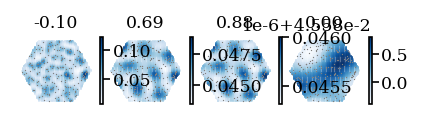

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming set_size, select_radii_idx, best_model, best_phases, 
# radii, optimal_grid_scores, idx_model, savefigs are defined elsewhere

figsize = set_size(fraction=(1/2,1/8), mode='square')
fig, axs = plt.subplots(1, len(select_radii_idx), figsize=figsize)

for i in range(len(select_radii_idx)):
    kde, mesh = best_model.phase_kde(bw_method=radii[select_radii_idx[i]])[:2]
    
    # Create scatter plot
    sc = axs[i].scatter(*mesh.T, c=kde, s=0.1, marker='s', linewidths=0.3)
    
    # Overlay grey scatter for best phases
    axs[i].scatter(*best_phases.T, s=0.1, marker='o', linewidths=0.3, color='grey')
    
    # Set axis properties
    axs[i].axis('off')
    axs[i].axis('equal')
    axs[i].set_title(f'{optimal_grid_scores[idx_model, select_radii_idx[i]]:.2f}', fontsize='small')
    
    # Add individual colorbar for each subplot
    cbar = fig.colorbar(sc, ax=axs[i], orientation='vertical', fraction=0.05, pad=0.04)
    
    # Uncomment this line to print min/max values for debugging
    # print(min(kde), max(kde))

# Remove whitespace between subplots and maximize figure size
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.75, wspace=0, hspace=0)

# Save the figure if necessary
if savefigs:
    fig.savefig('../results/P3-phase_kde_best')

-0.18496031781513397 0.21801947737307803 0.07671656089804833
-0.10859774677579112 0.18949953827102387 0.06276814709572284
-0.11626142914380293 0.17016600622614347 0.06318850965764232
-0.5757576426834371 0.8276816389567799 0.38778991530390117


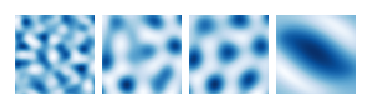

In [23]:
# plot autocorrelograms for best model and selected radii
figsize = set_size(fraction=(1/2,1/8),mode='square')
fig, axs = plt.subplots(1,len(select_radii_idx),figsize=figsize)
for i in range(len(select_radii_idx)):
    autocorr = best_model.phase_kde_autocorrelogram(bw_method=radii[select_radii_idx[i]])[0]
    axs[i].imshow(autocorr, extent=[np.min(square_mesh),np.max(square_mesh),np.min(square_mesh),np.max(square_mesh)])
    axs[i].axis('off')
    print(np.min(autocorr),np.max(autocorr), np.std(autocorr))
# remove whitespace between subplots and maximize figure size
fig.subplots_adjust(left=0.025, right=0.975, bottom=0, top=1, wspace=0.1, hspace=0)
if savefigs:
    fig.savefig('../results/P3-phase_kde_autocorrelogram_best')

0.05635724209619403 2.276126137043857 0.38107169752369363
0.6465703960168059 1.1807860802108543 0.12522275465760568
0.7448084137316534 0.9339847391464056 0.04512864137824683
0.8542037938434276 0.8787381137322451 0.006501550831578824


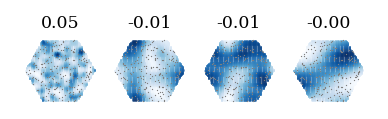

In [38]:
# plot kdes for random model and selected radii
figsize = set_size(fraction=(1/2,1/8),mode='square')
fig, axs = plt.subplots(1,len(select_radii_idx),figsize=figsize)

for i in range(len(select_radii_idx)):
    random_phases = best_model.unit_cell.sample(len(best_model.phases))
    kde, mesh = model.phase_kde(bw_method=radii[select_radii_idx[i]], phases=random_phases)[:2]
    kde = kde / (np.sum(kde) * model.unit_cell.area / len(kde)) # normalize to unit integral
    grid_score = model.grid_score(phases=random_phases, bw_method=radii[select_radii_idx[i]])
    axs[i].scatter(*mesh.T, c=kde, s=0.1, marker='s', linewidths=0.3)
    axs[i].scatter(*best_phases.T, s=0.1, marker='o', linewidths=0.3, color='grey')
    axs[i].axis('off')
    axs[i].axis('equal')
    axs[i].set_title(f'{grid_score:.2f}',fontsize='small')
    #ax.set_position([0,0,1,1])
    print(min(kde),max(kde), np.std(kde))
# remove whitespace between subplots and maximize figure size
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.75, wspace=0, hspace=0)
if savefigs:
    fig.savefig('../results/P3-phase_kde_random')

-0.24386488115459648 0.2941551421852207 0.11571469650665583
-0.7546871666869022 0.8346978148053135 0.3729086179384504
-0.8113999059573187 0.8730439177636938 0.41039981718609014
-0.8016631982528636 0.8702281845877912 0.42184777900779713


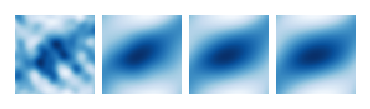

In [25]:
# plot autocorrelograms for random model and selected radii
figsize = set_size(fraction=(1/2,1/8),mode='square')
fig, axs = plt.subplots(1,len(select_radii_idx),figsize=figsize)
for i in range(len(select_radii_idx)):
    autocorr = best_model.phase_kde_autocorrelogram(bw_method=radii[select_radii_idx[i]], phases=random_phases)[0]
    axs[i].imshow(autocorr, extent=[np.min(square_mesh),np.max(square_mesh),np.min(square_mesh),np.max(square_mesh)])
    axs[i].axis('off')
    print(np.min(autocorr),np.max(autocorr), np.std(autocorr))
# remove whitespace between subplots and maximize figure size
fig.subplots_adjust(left=0.025, right=0.975, bottom=0, top=1, wspace=0.1, hspace=0)
if savefigs:
    fig.savefig('../results/P3-phase_kde_autocorrelogram_random')